In [ ]:
# Note, i ran this code in google colab.
# Step1: load dataset (pip install datasets)
from datasets import load_dataset

data = load_dataset("zh-plus/tiny-imagenet")
data['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})

In [ ]:
print(data["train"][0])
print(data["train"].features)
label_names = data["train"].features["label"].names
print("Number of labels:", len(label_names))

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7FBD20C01090>, 'label': 0}
{'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666347', 'n02669723', 'n02699494', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440

In [ ]:
label_names = data["train"].features["label"].names

In [ ]:
label2id, id2label = {}, {}
for i, label in enumerate(label_names): # each class corresponding to a number and regarding that number we could recover the number.
    label2id[label] = i
    id2label[i] = label

In [ ]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

IMG_SIZE = 224
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

train_transforms = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),   # no crop, just resize to 224x224 (I dont want the augmentation)
    ToTensor(),
    normalize,
])

val_transforms = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),   # same as train
    ToTensor(),
    normalize,
])

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
train_ds = data['train']
val_ds = data['valid']

train_ds.set_transform(preprocess_train)# The .set_transform() method in Hugging Face's datasets library is used to apply a transformation function to a dataset.
val_ds.set_transform(preprocess_val)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
image_processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

checkpoint = "google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    label2id=label2id,
    id2label=id2label,
)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 743,624 || all params: 86,696,080 || trainable%: 0.8577


In [ ]:
from transformers import TrainingArguments, Trainer
from datetime import datetime

peft_model_id = f"./imagenet-{datetime.now().strftime('%Y%m%d-%H%M%S')}"   #output directory where checkpoints and logs will be saved.

batch_size = 16

args = TrainingArguments(
    peft_model_id,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=1,
    logging_steps=10,
    load_best_model_at_end=True,
    label_names=["labels"],
    report_to=[]
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=image_processor,
    data_collator=collate_fn,

)
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.463700,0.470107


TrainOutput(global_step=1563, training_loss=0.4572531124833144, metrics={'train_runtime': 912.28, 'train_samples_per_second': 109.615, 'train_steps_per_second': 1.713, 'total_flos': 7.830112518144e+18, 'train_loss': 0.4572531124833144, 'epoch': 1.0})

In [ ]:
# Eval metrics on validation set
eval_metrics = trainer.evaluate()
print("Eval metrics:", eval_metrics)

Eval metrics: {'eval_loss': 0.4701066315174103, 'eval_runtime': 46.1745, 'eval_samples_per_second': 216.57, 'eval_steps_per_second': 13.536, 'epoch': 1.0}


In [ ]:
pred = trainer.predict(val_ds) # should i pick a test data that is not in validation

In [ ]:
pred

PredictionOutput(predictions=array([[ 1.21406250e+01, -3.63037109e-01, -1.93847656e-01, ...,
         2.20825195e-01, -3.33251953e-01, -4.06494141e-01],
       [ 1.17031250e+01, -9.24316406e-01,  7.84179688e-01, ...,
         1.32324219e-01,  1.97265625e-01,  4.62402344e-01],
       [ 1.28437500e+01, -9.14062500e-01,  1.05773926e-01, ...,
         8.54492188e-02, -1.86004639e-02, -9.33837891e-03],
       ...,
       [-6.25976562e-01, -6.59179688e-01, -5.82519531e-01, ...,
         1.82617188e-01, -1.82373047e-01,  1.13593750e+01],
       [-6.47949219e-01, -1.35546875e+00, -5.04394531e-01, ...,
         2.70263672e-01,  8.35449219e-01,  1.13906250e+01],
       [-1.09277344e+00, -6.15234375e-01, -1.41894531e+00, ...,
         2.53662109e-01, -1.38183594e-01,  1.06093750e+01]], dtype=float32), label_ids=array([  0,   0,   0, ..., 199, 199, 199]), metrics={'test_loss': 0.4701066315174103, 'test_runtime': 51.6204, 'test_samples_per_second': 193.722, 'test_steps_per_second': 12.108})

In [ ]:
# Convert logits -> predicted labels
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = np.argmax(pred.predictions, axis=1)
y_true = pred.label_ids

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=90, cmap="Blues")
plt.show()

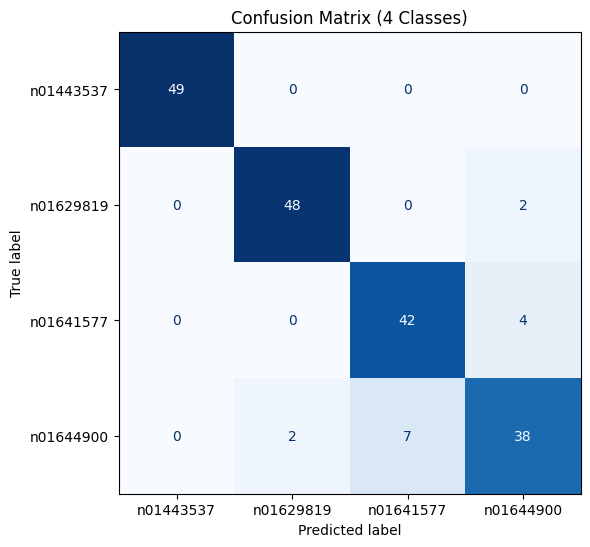

In [ ]:
# Select only the 4 classes you want
selected_classes = [0, 1, 2, 3]  # change to the label IDs you want
mask = np.isin(y_true, selected_classes)

y_true_sub = y_true[mask]
y_pred_sub = y_pred[mask]

# Also filter predictions to only those classes
mask_pred = np.isin(y_pred_sub, selected_classes)
y_true_sub = y_true_sub[mask_pred]
y_pred_sub = y_pred_sub[mask_pred]

# Compute confusion matrix for selected classes
cm = confusion_matrix(y_true_sub, y_pred_sub, labels=selected_classes)

# Get class names
class_names = [id2label[i] for i in selected_classes]

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (4 Classes)")
plt.show()
